In [18]:
# import necessary packages
import os, sys, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import cv2

from tqdm.auto import tqdm
from PIL import Image
from scipy import ndimage
from skimage.segmentation import watershed
from skimage.feature import peak_local_max


# append paths
sys.path.append('../')
sys.path.append('../utils')

# import custom functions
from BuildUNet import BuildUNet
from GetLowestGPU import GetLowestGPU
from TileGenerator import TileGenerator

In [19]:
# load images
pred_path = "../pennycress_pods/predictions/"
image_save_path = "../pennycress_pods/predictions_by_pod/"
seed_save_path = "../pennycress_pods/seed_counts/"

pred_image_names = glob.glob(pred_path + "*.png")
pred_image_names = [os.path.basename(x) for x in pred_image_names]

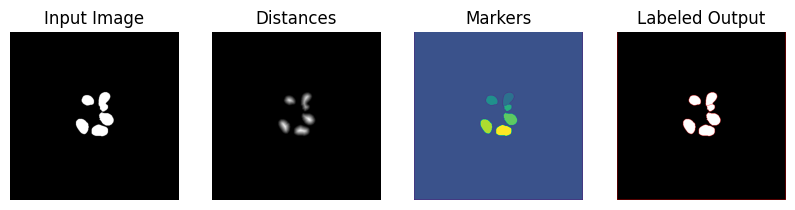

seed count: 6


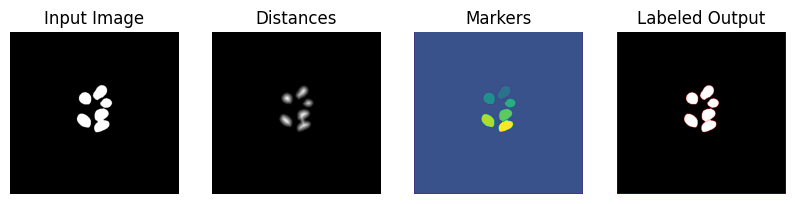

seed count: 6


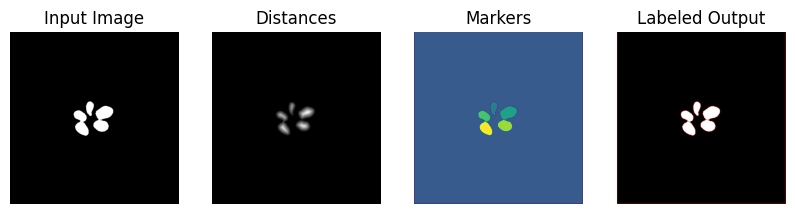

seed count: 5


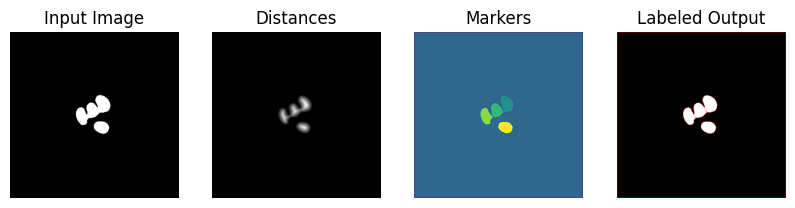

seed count: 4


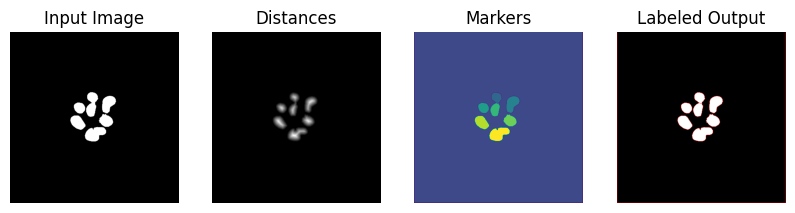

seed count: 7


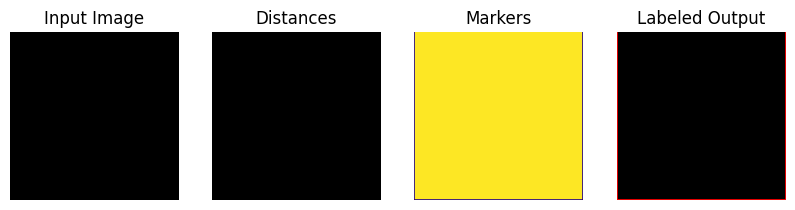

seed count: 0


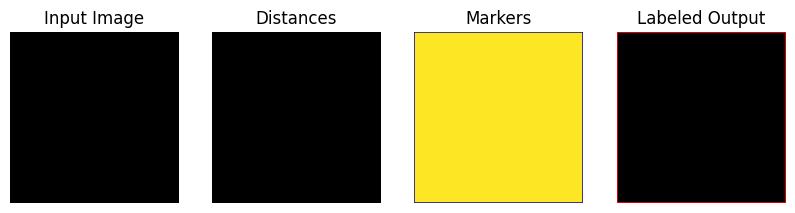

seed count: 0


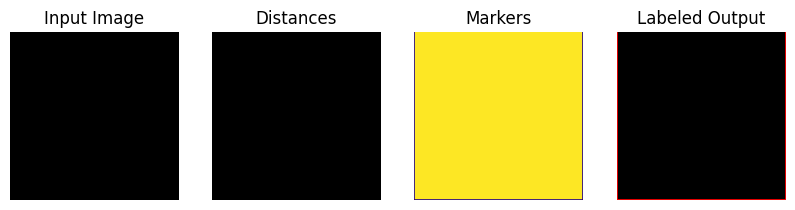

seed count: 0


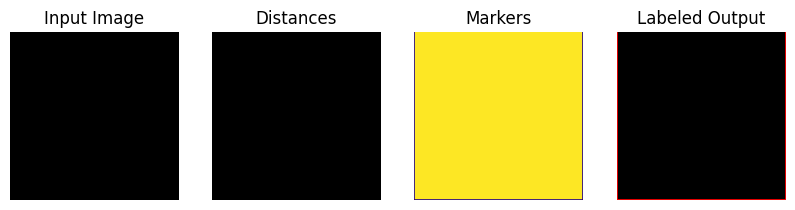

seed count: 0


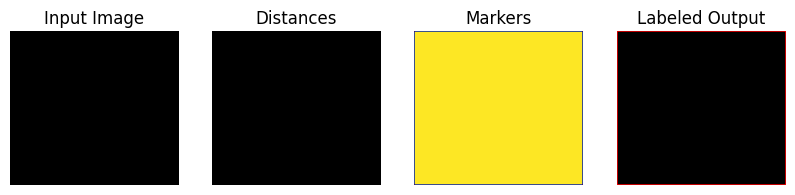

seed count: 0


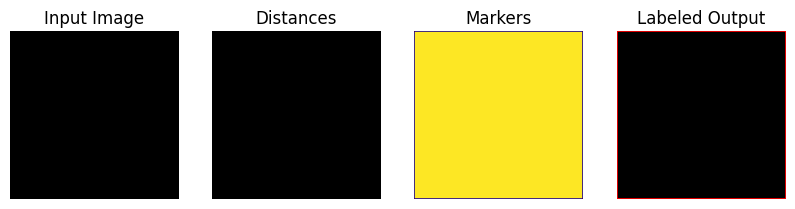

seed count: 0


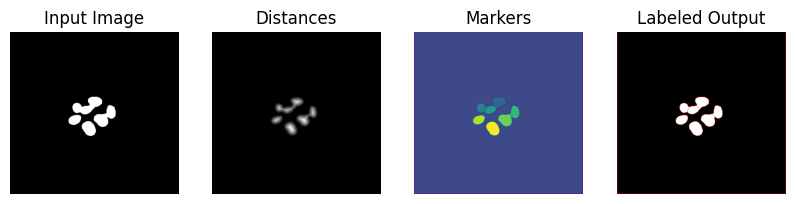

seed count: 7


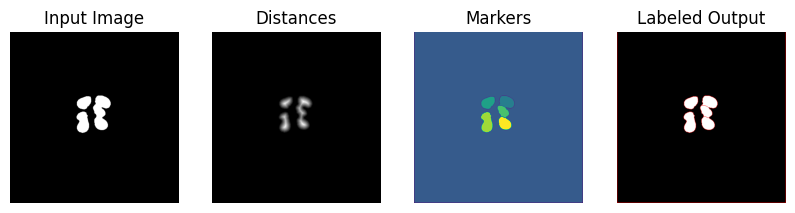

seed count: 5


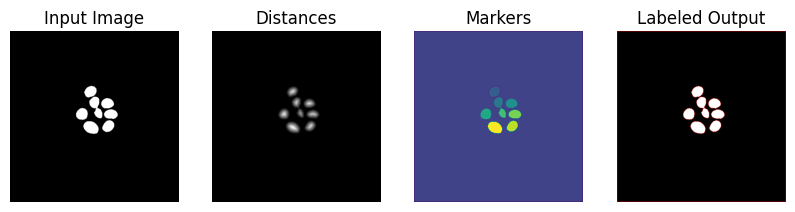

seed count: 8


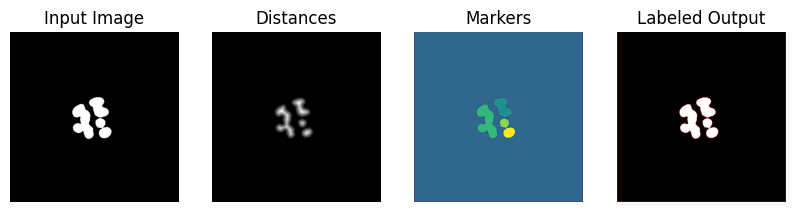

seed count: 4


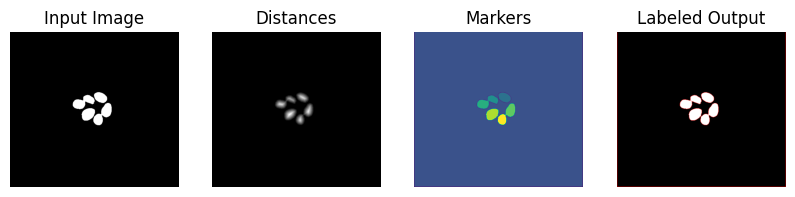

seed count: 7


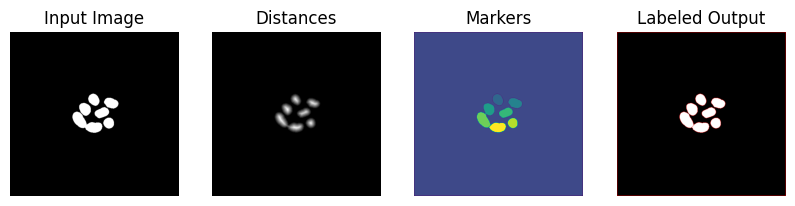

seed count: 7


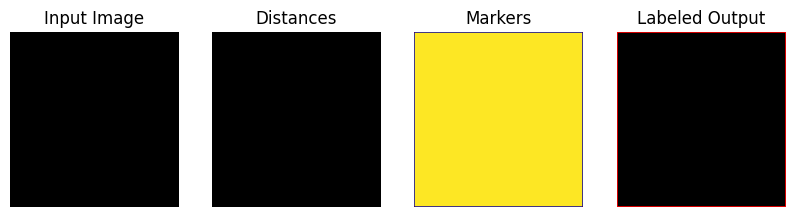

seed count: 0


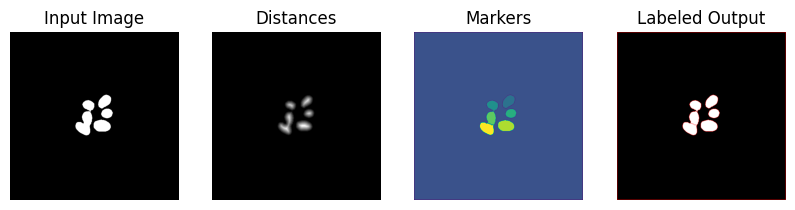

seed count: 6


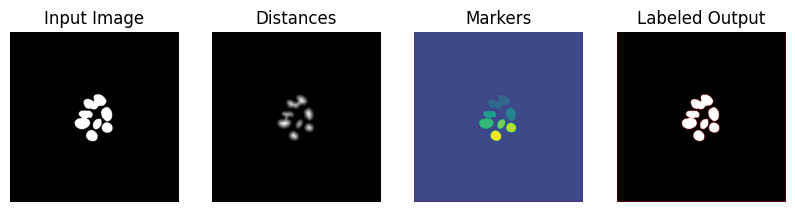

seed count: 7


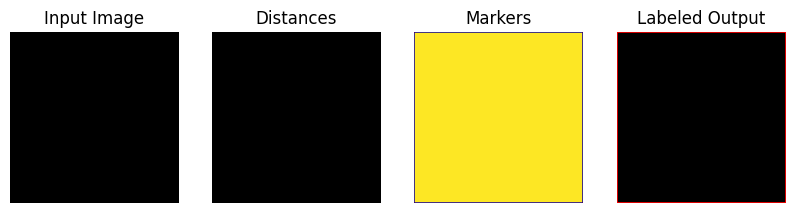

seed count: 0


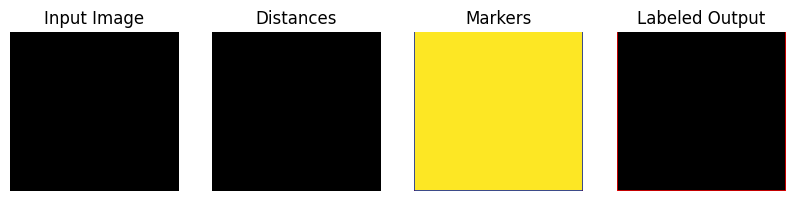

seed count: 0


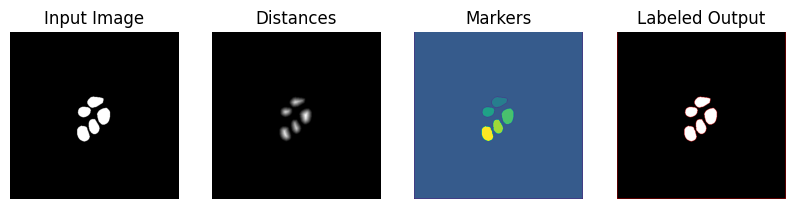

seed count: 5


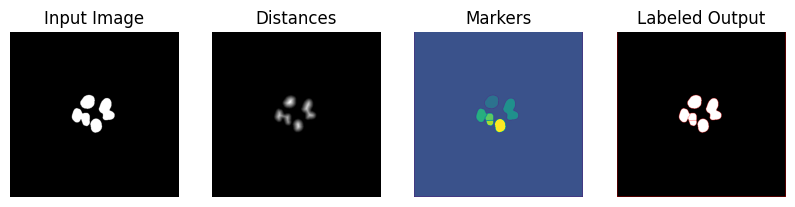

seed count: 6


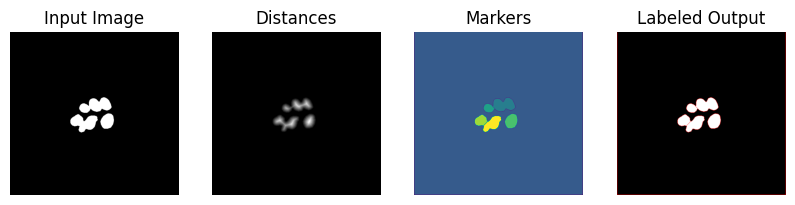

seed count: 5


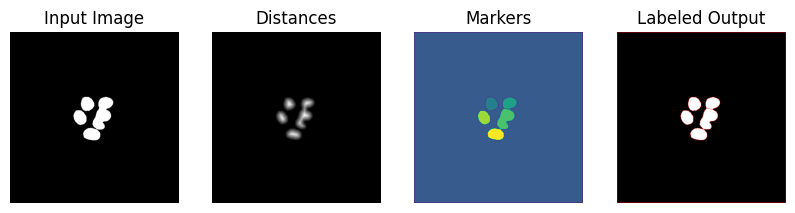

seed count: 5


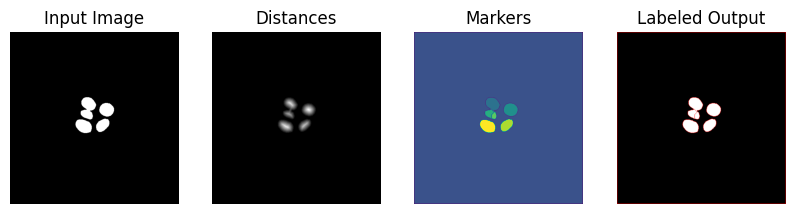

seed count: 6


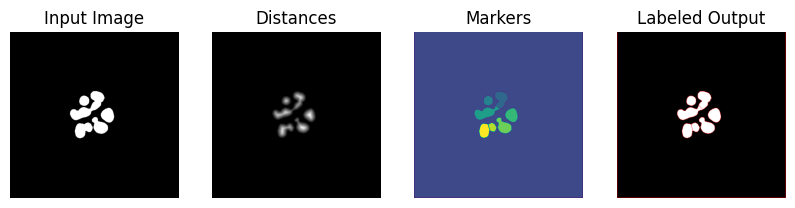

seed count: 7


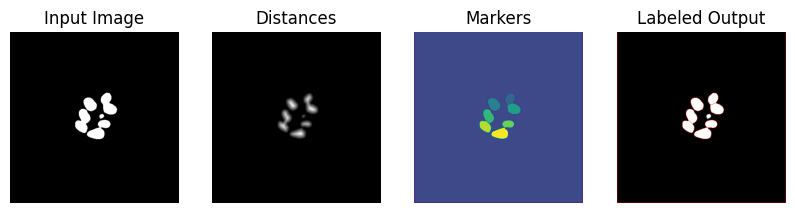

seed count: 7


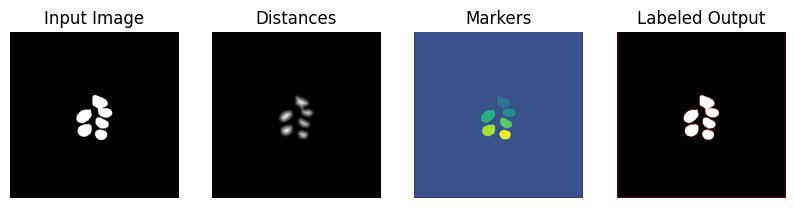

seed count: 6


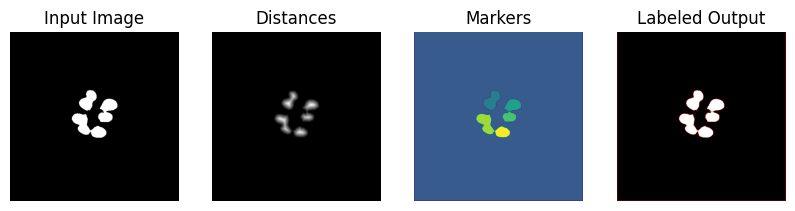

seed count: 5


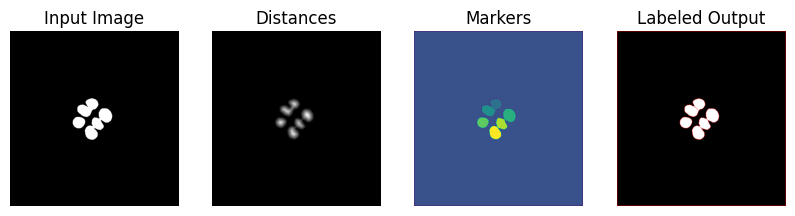

seed count: 6


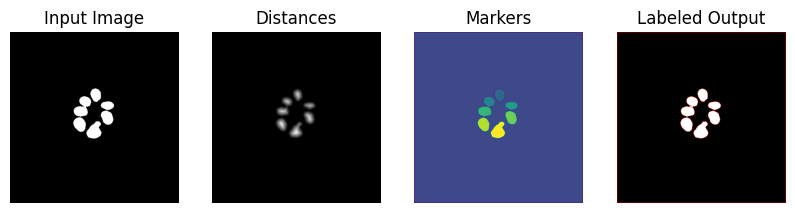

seed count: 7


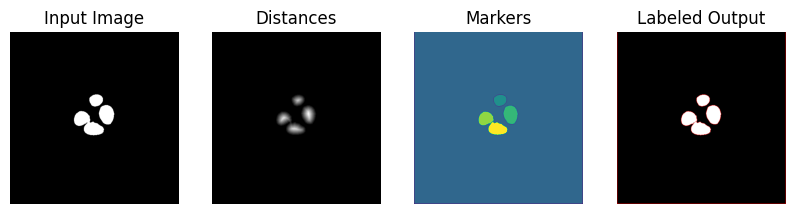

seed count: 4


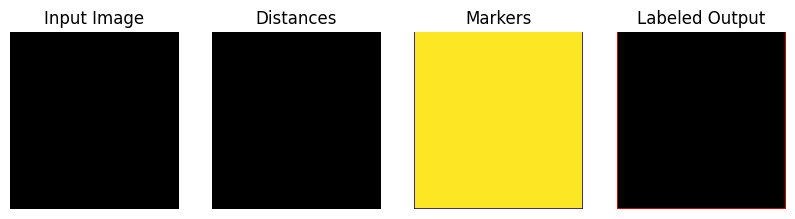

seed count: 0


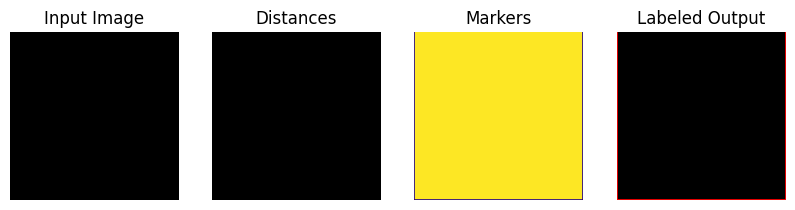

seed count: 0


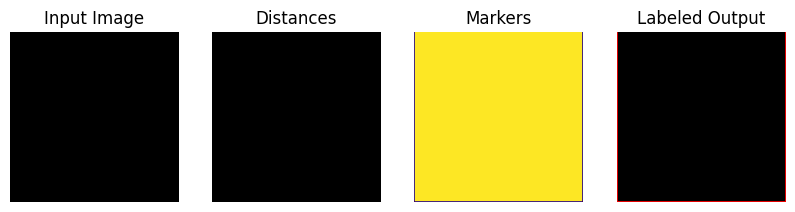

seed count: 0


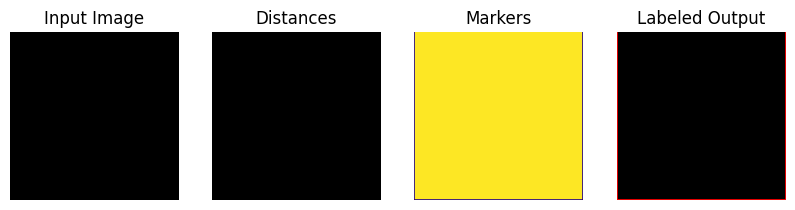

seed count: 0


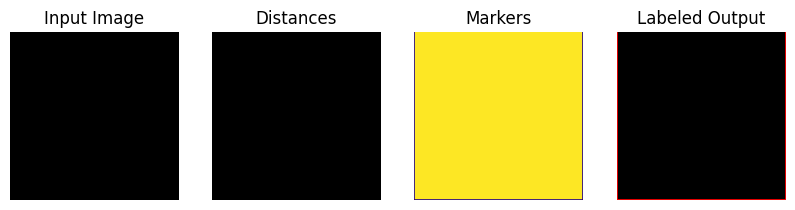

seed count: 0


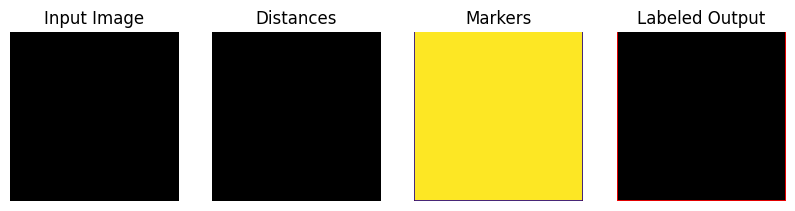

seed count: 0


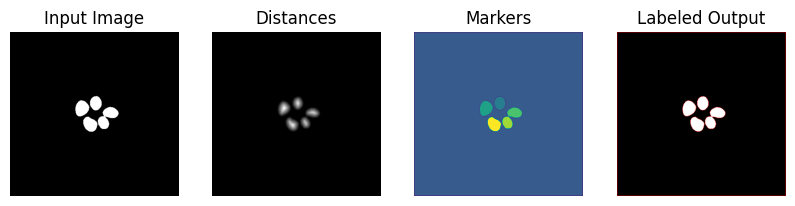

seed count: 5


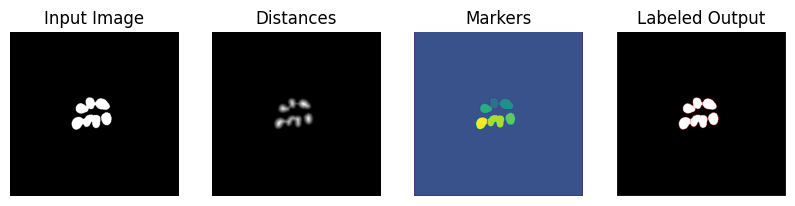

seed count: 6


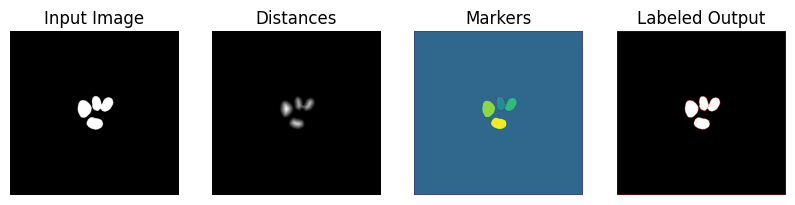

seed count: 4


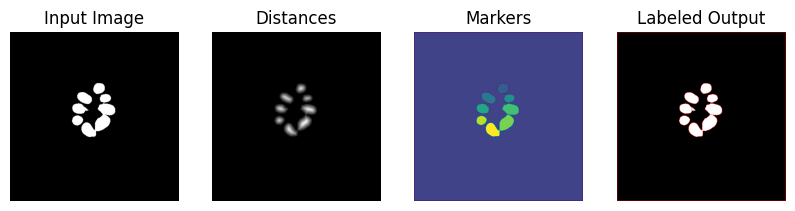

seed count: 8


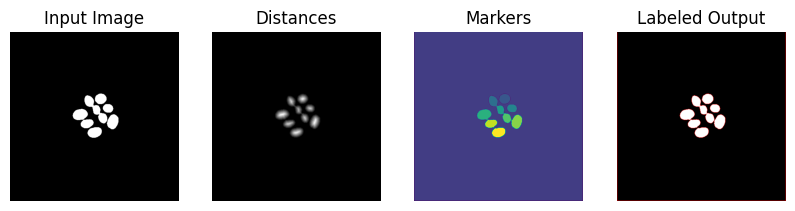

seed count: 9


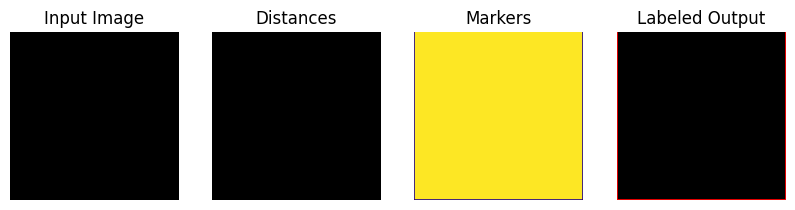

seed count: 0


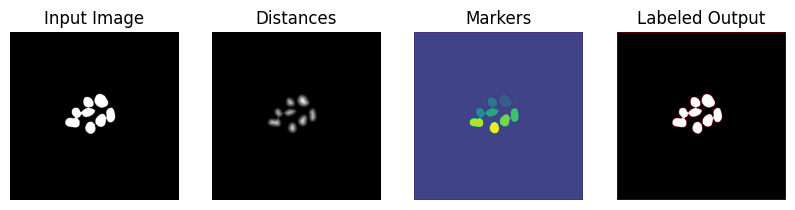

seed count: 8


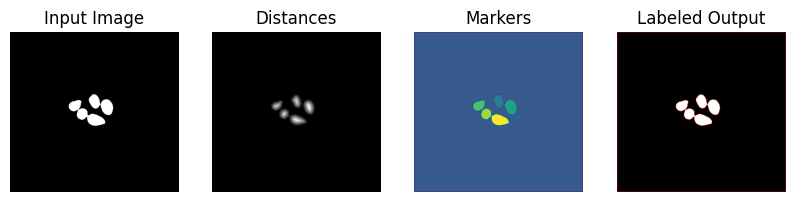

seed count: 5


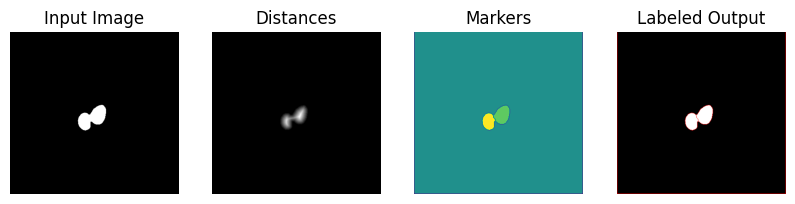

seed count: 2


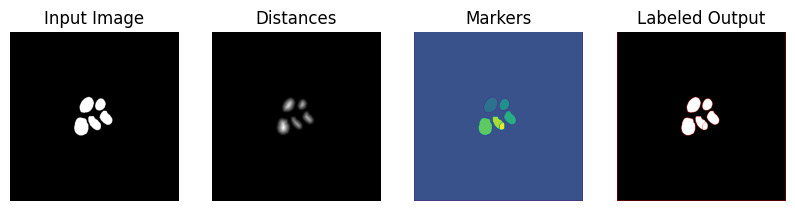

seed count: 6


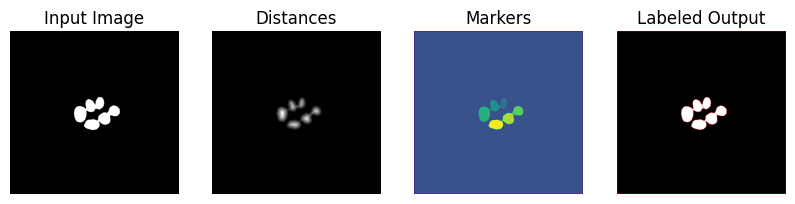

seed count: 6


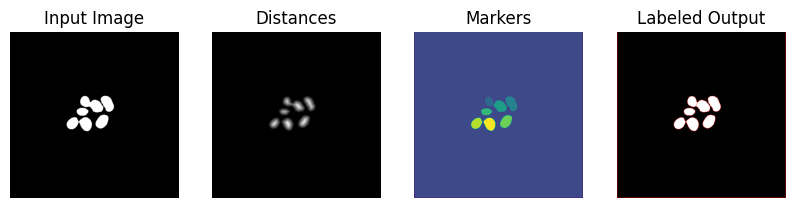

seed count: 7


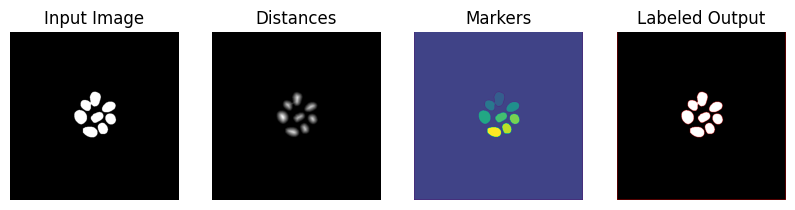

seed count: 8


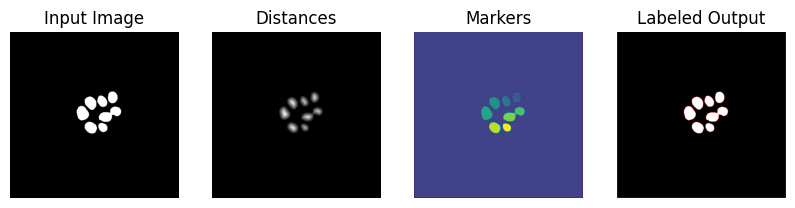

seed count: 8


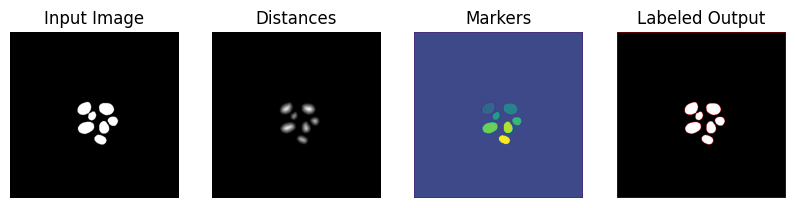

seed count: 7


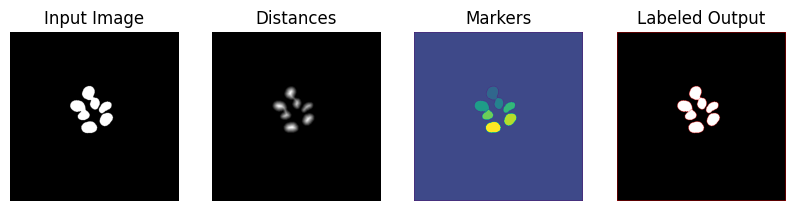

seed count: 7


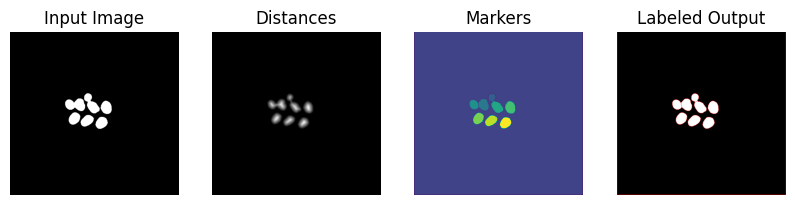

seed count: 8


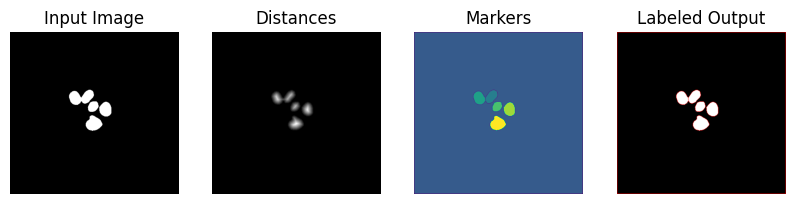

seed count: 5


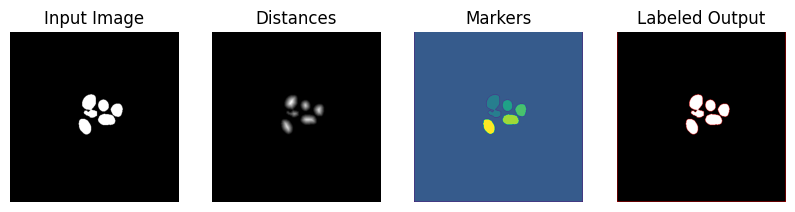

seed count: 5


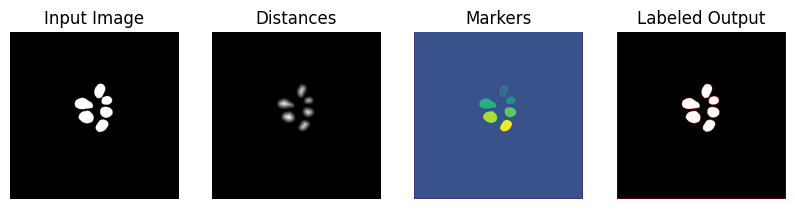

seed count: 6


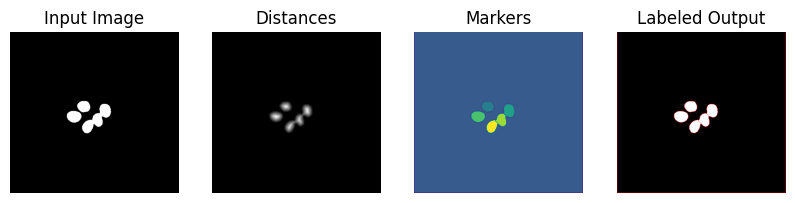

seed count: 5


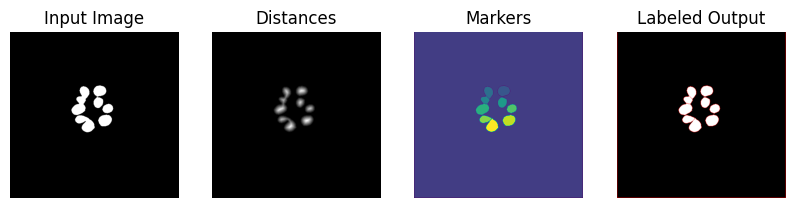

seed count: 9


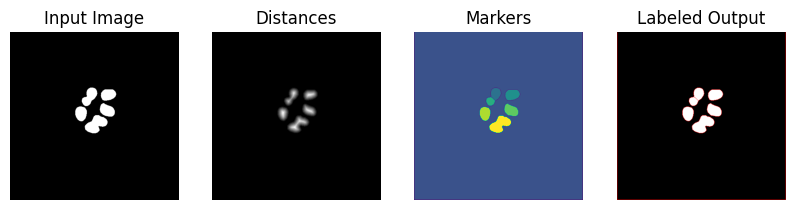

seed count: 6


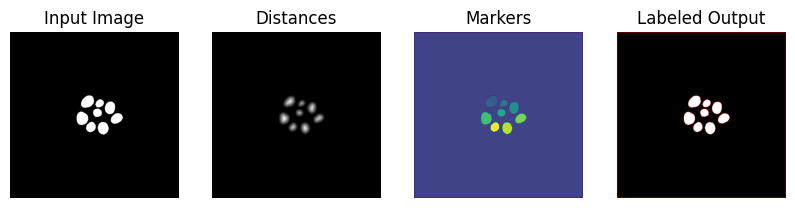

seed count: 8


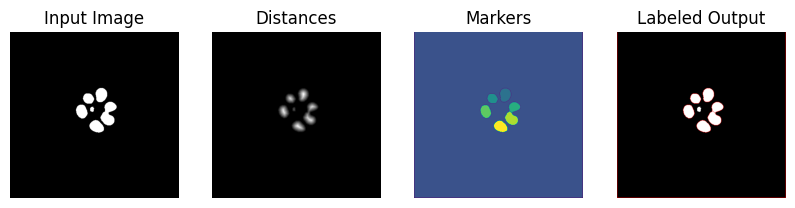

seed count: 6


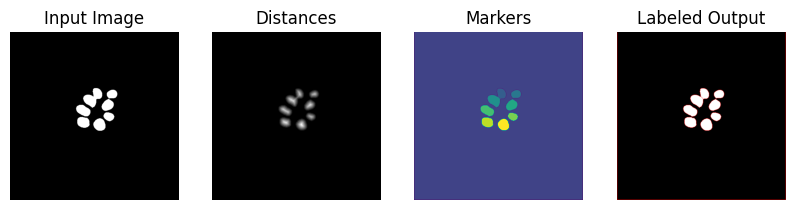

seed count: 8


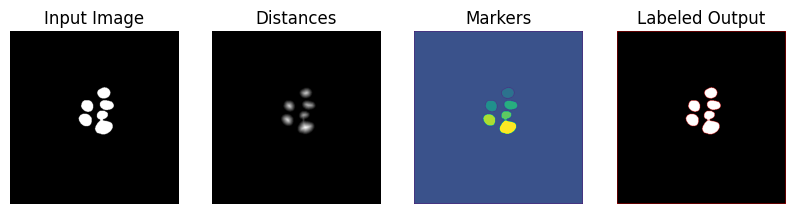

seed count: 6


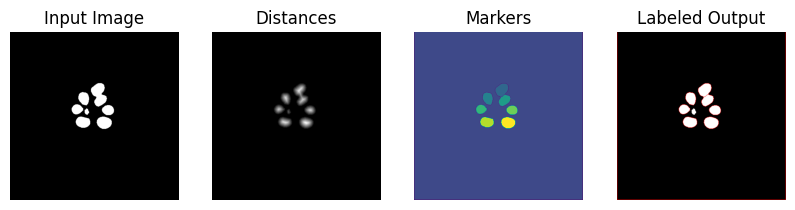

seed count: 7


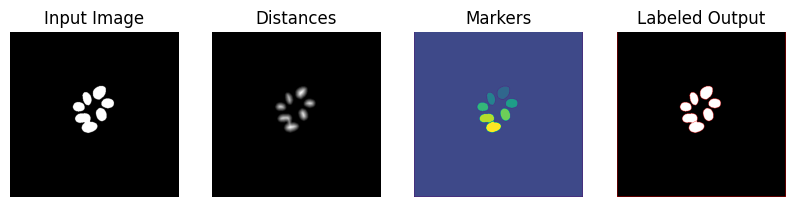

seed count: 7


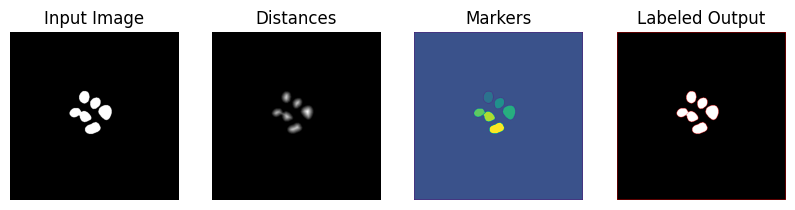

seed count: 6


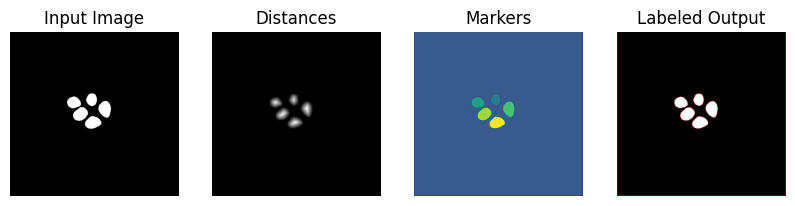

seed count: 5


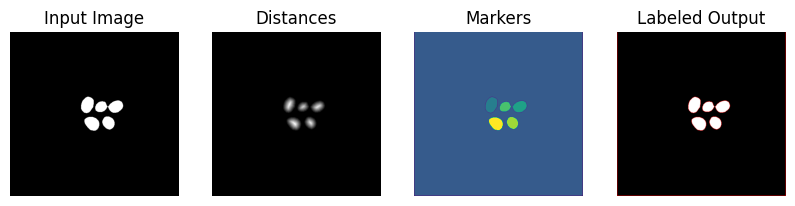

seed count: 5


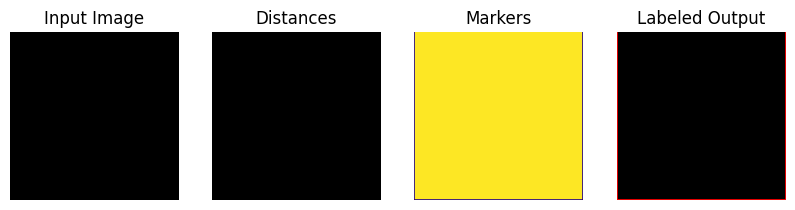

seed count: 0


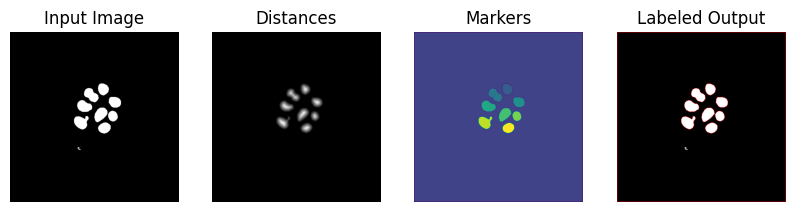

seed count: 8


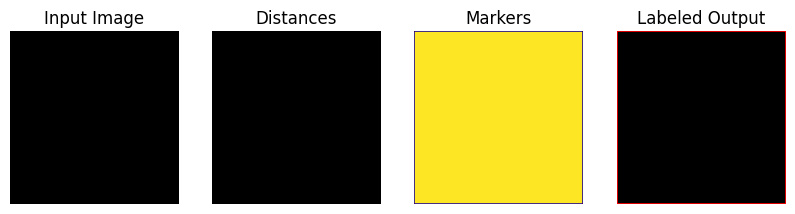

seed count: 0


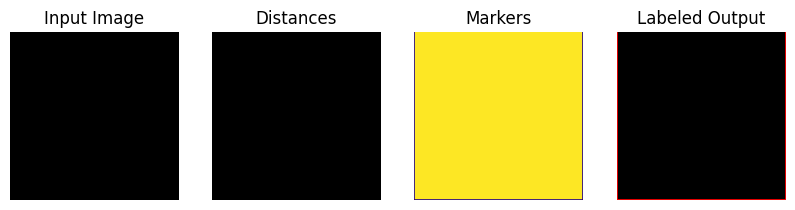

seed count: 0


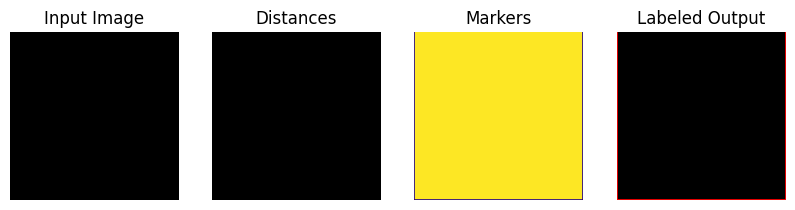

seed count: 0


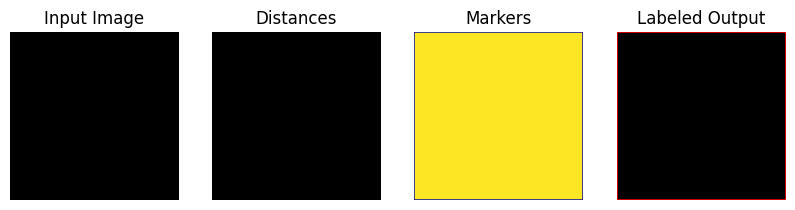

seed count: 0


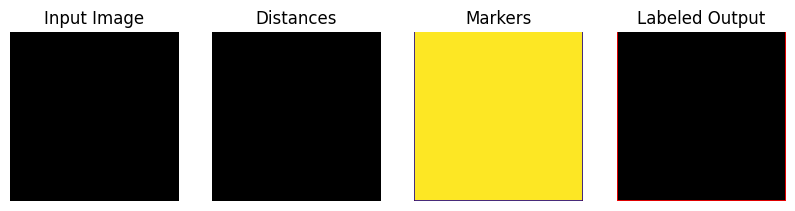

seed count: 0


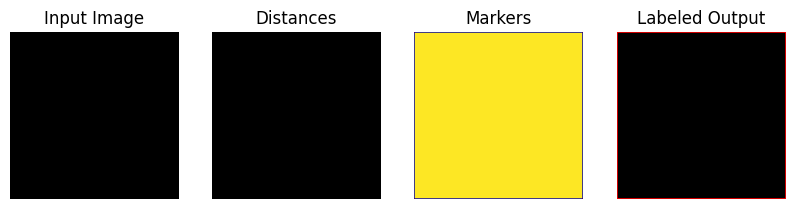

seed count: 0


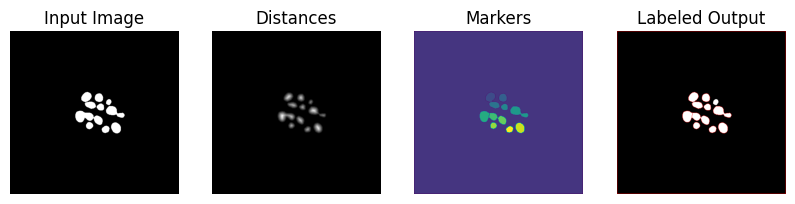

seed count: 11


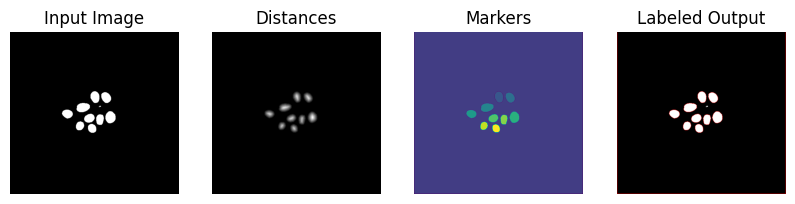

seed count: 9


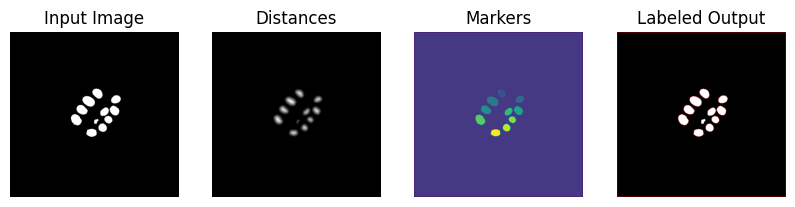

seed count: 10


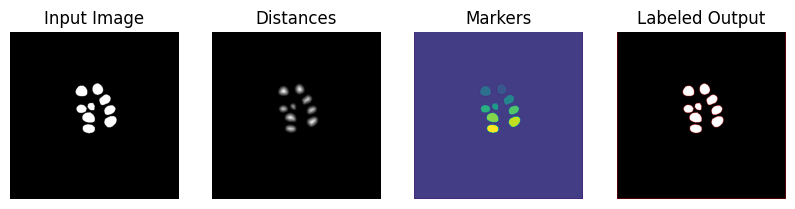

seed count: 9


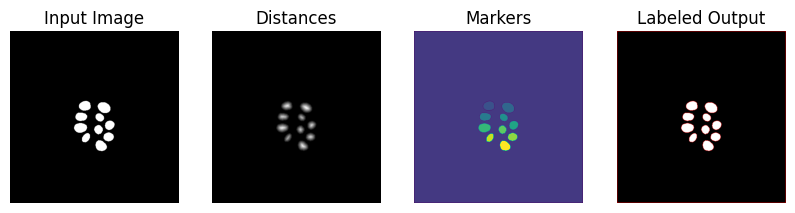

seed count: 10


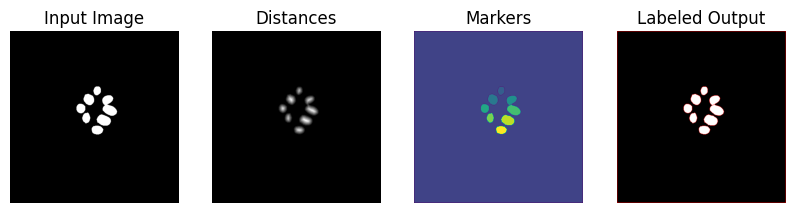

seed count: 8


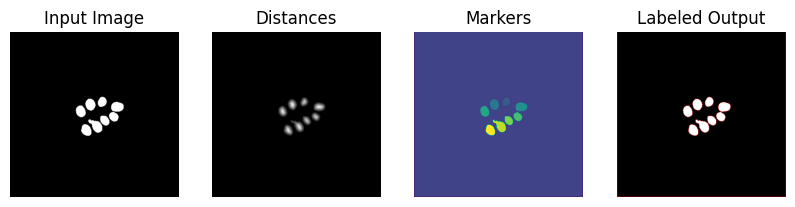

seed count: 8


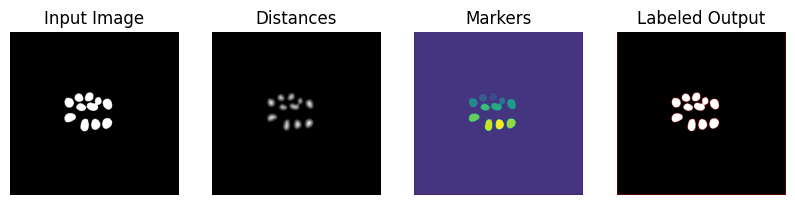

seed count: 11


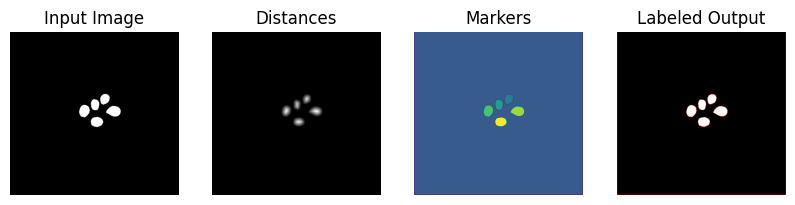

seed count: 5


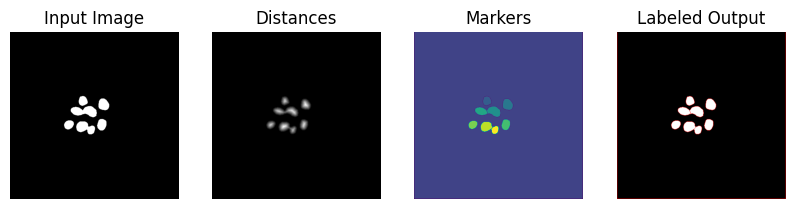

seed count: 8


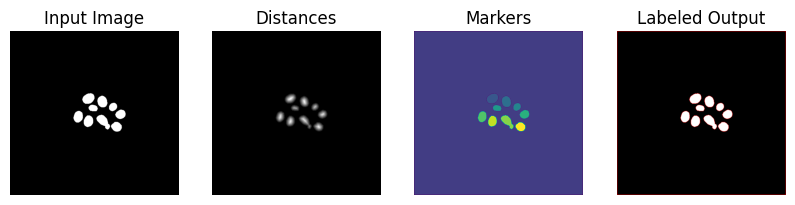

seed count: 9


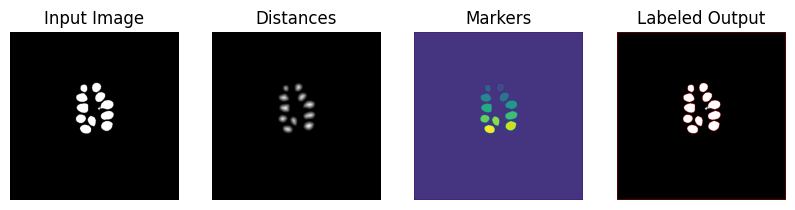

seed count: 11


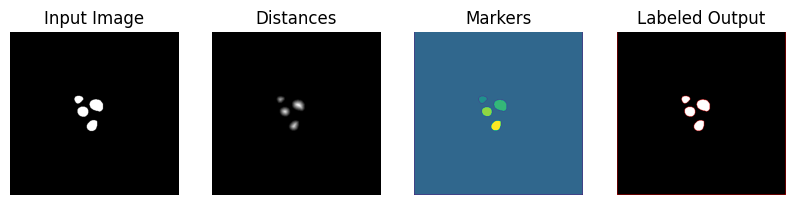

seed count: 4


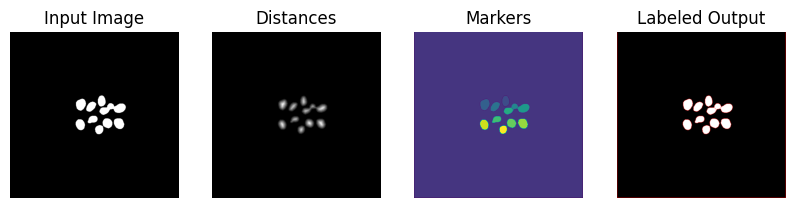

seed count: 11


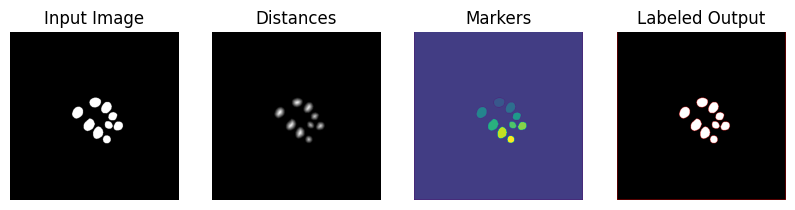

seed count: 9


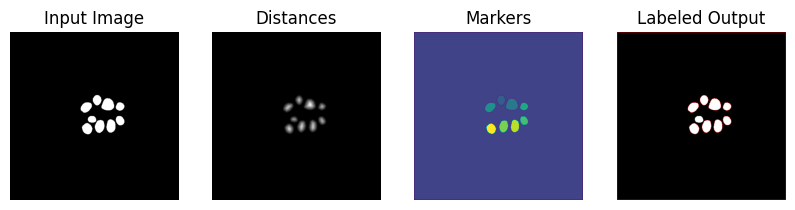

seed count: 8


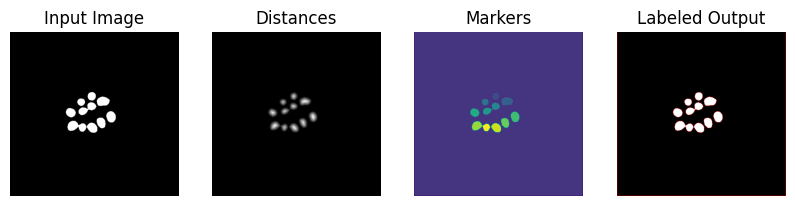

seed count: 11


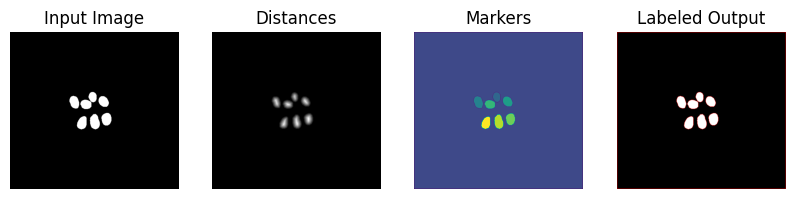

seed count: 8


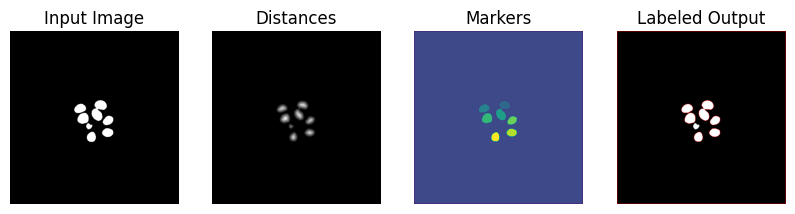

seed count: 7


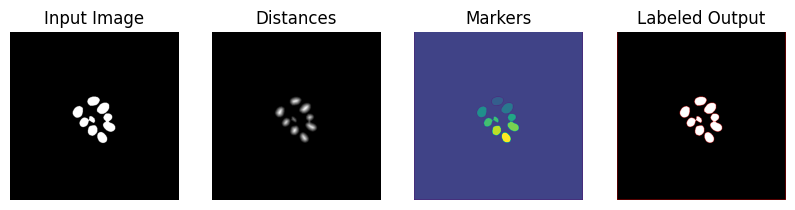

seed count: 8


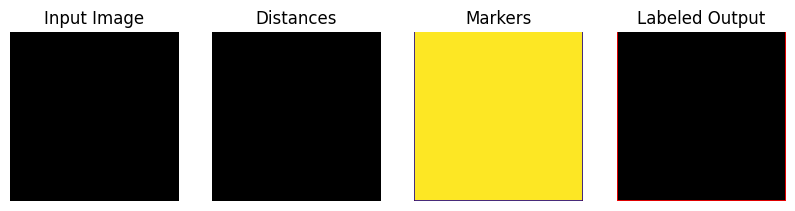

seed count: 0


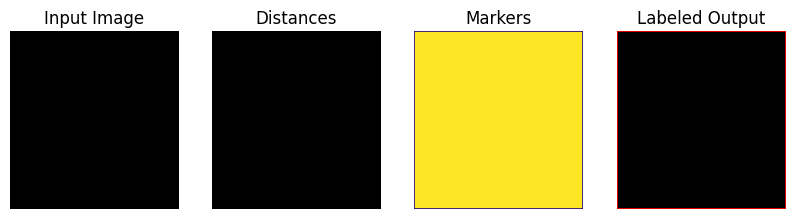

seed count: 0


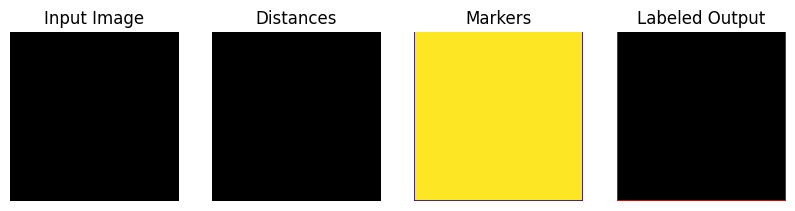

seed count: 0


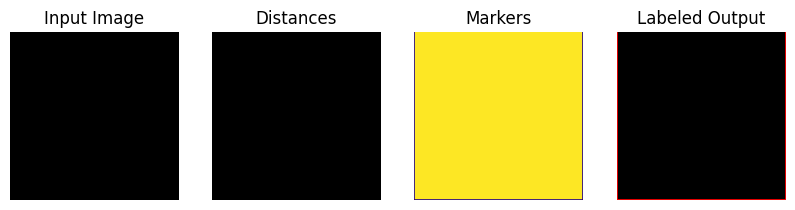

seed count: 0


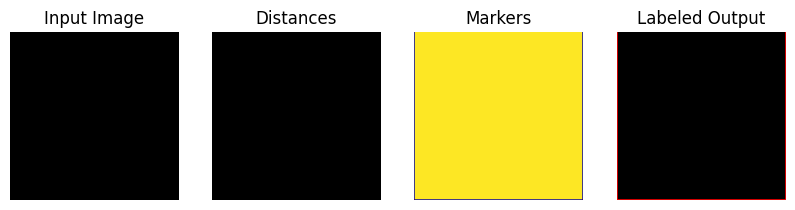

seed count: 0


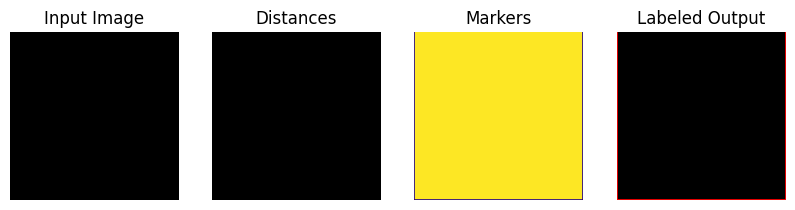

seed count: 0


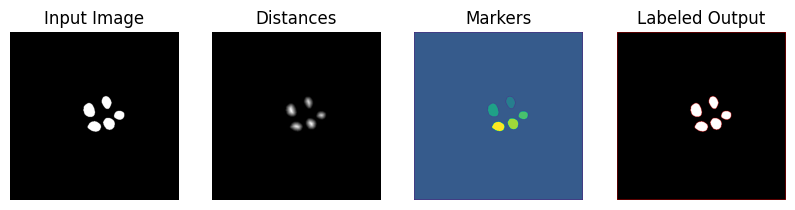

seed count: 5


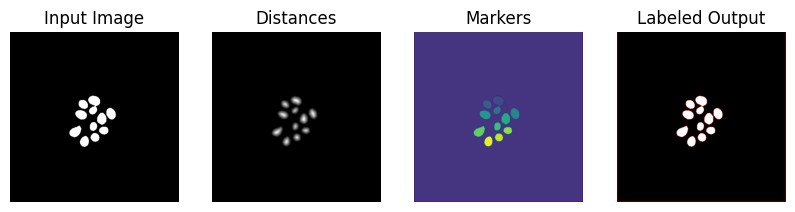

seed count: 11


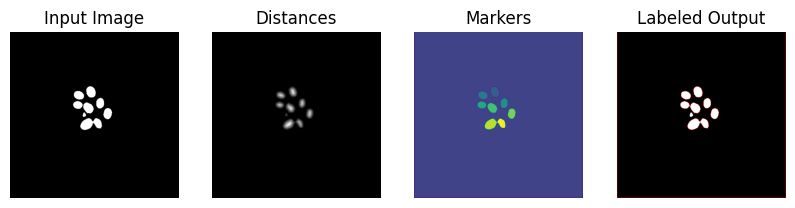

seed count: 8


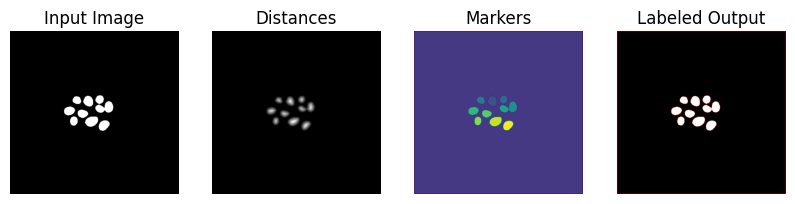

seed count: 10


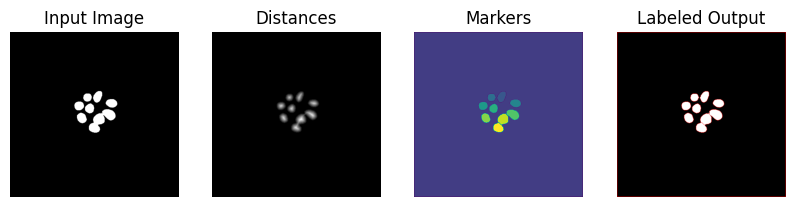

seed count: 9


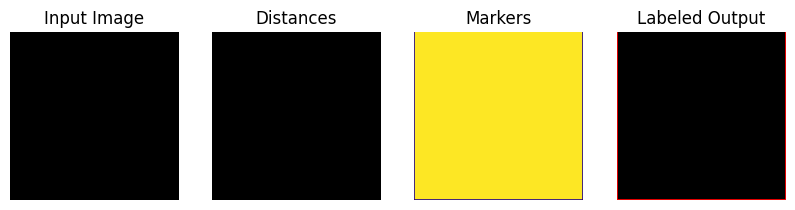

seed count: 0


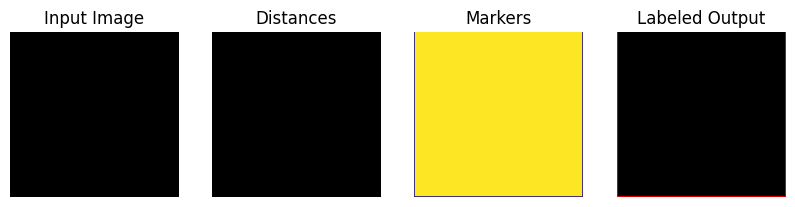

seed count: 0


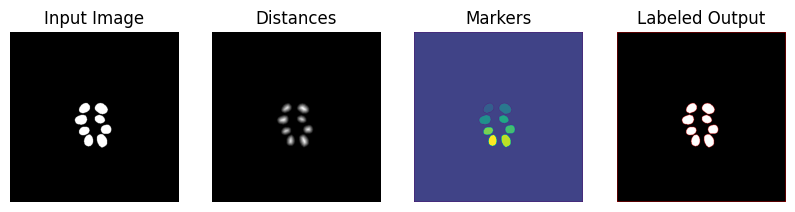

seed count: 8


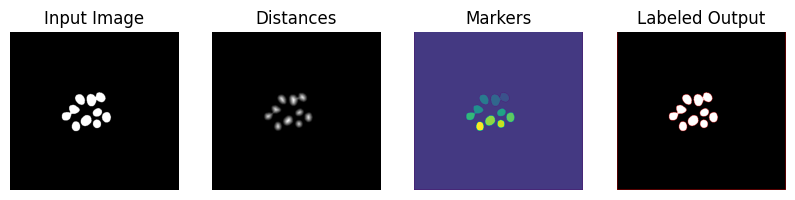

seed count: 10


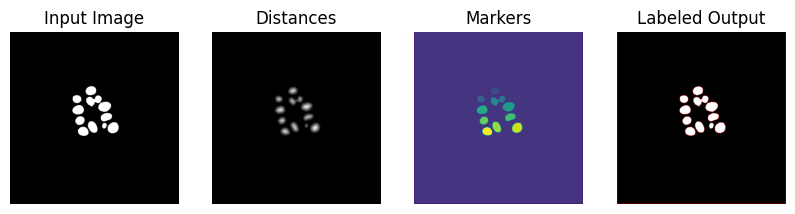

seed count: 11


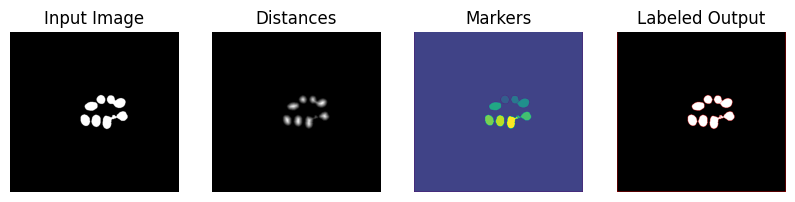

seed count: 8


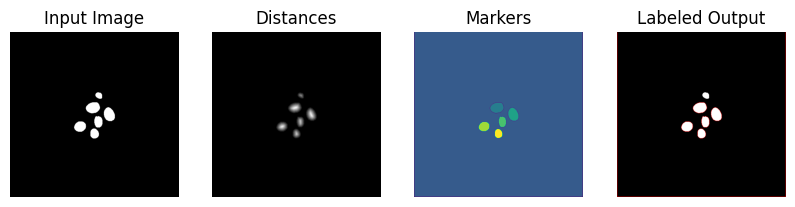

seed count: 5


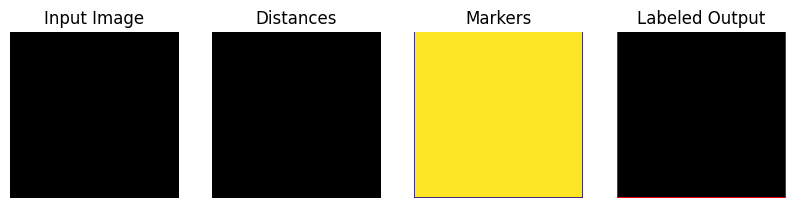

seed count: 0


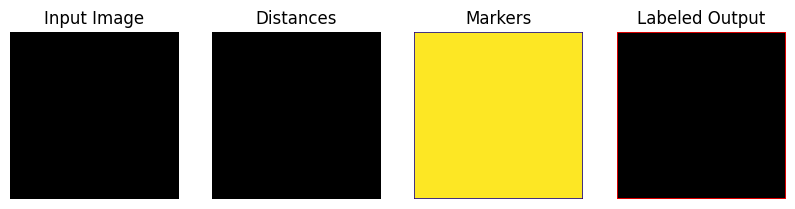

seed count: 0


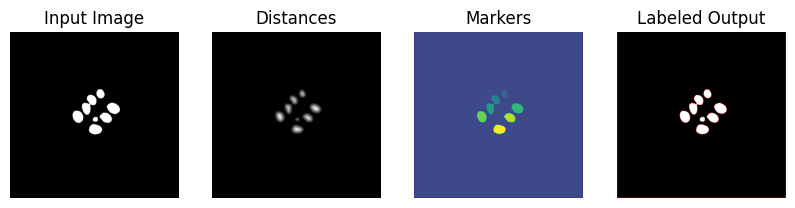

seed count: 7


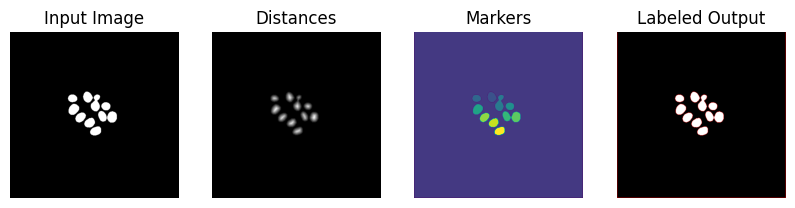

seed count: 10


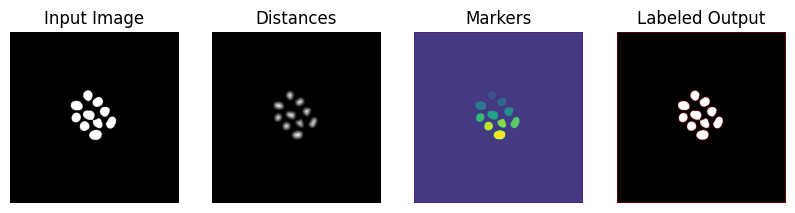

seed count: 10


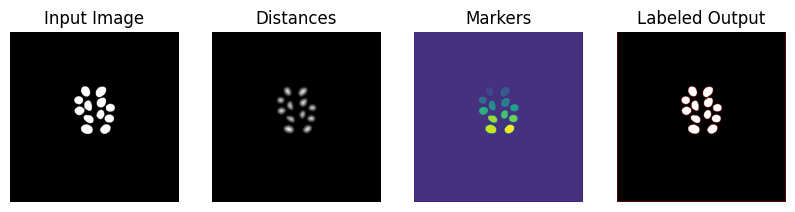

seed count: 12


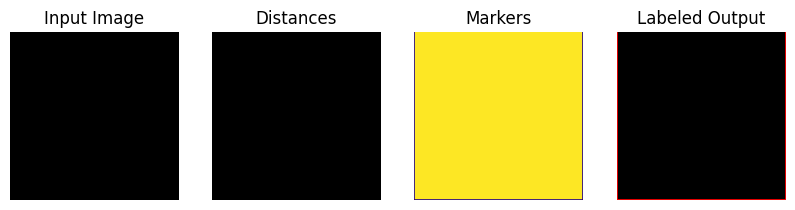

seed count: 0


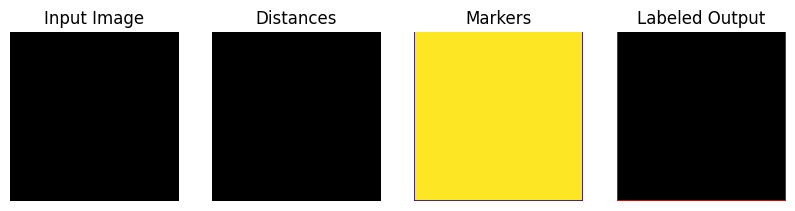

seed count: 0


In [20]:
# Seed Counting

for pred_image_name in pred_image_names:

        # for a single image:
        pred_image = Image.open(pred_path + pred_image_name)
        pred_image = np.array(pred_image) / 255 
        
        # revert white background to black
        pred_image[pred_image.sum(axis=2) == 3] = 0

        # pad image so that we can draw bounding box around it
        pred_image = np.pad(pred_image, ((100, 100), (100, 100), (0, 0)), mode='constant')

        # extract bool mask for object detection
        bool_mask = np.array(pred_image).sum(axis=2) > .5 # convert to boolean mask

        # label each object in the image and draw bounding box around it
        labels = ndimage.label(bool_mask)[0]
        bboxes = ndimage.find_objects(labels)

        # add padding to bounding boxes
        x_pad, y_pad = 100, 100
        for i in range(len(bboxes)):
                x, y = bboxes[i]
                bboxes[i] = slice(x.start-x_pad, x.stop+x_pad), slice(y.start-y_pad, y.stop+y_pad)


        # create list to store seed counts
        seed_counts = []

        # loop through split images
        for i, bbox in enumerate(bboxes):
                y, x = bbox
                split_image = pred_image[y, x, :]

                # extract only the blue channel (seeds) from the image
                image = split_image[:, :, 2].astype(np.int64)

                # change image type and make 3-channel mask
                image = image.astype(np.uint8) * 255

                # define kernel for operations
                kernel = np.ones((3,3),np.uint8)

                # # erode image to define splits
                # image = cv2.erode(image, kernel, iterations=2)

                rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

                # noise removal
                opening = cv2.morphologyEx(image,
                                           cv2.MORPH_OPEN,kernel,
                                           iterations = 2)
                
                # sure background area
                sure_bg = cv2.dilate(opening,
                                     kernel,
                                     iterations=3)
                
                # Finding sure foreground area
                dist_transform = cv2.distanceTransform(opening,
                                                       cv2.DIST_L2,
                                                       5)
                ret, sure_fg = cv2.threshold(dist_transform,
                                             0.6*dist_transform.max(),
                                             255,
                                             0)
                
                # Finding unknown region
                sure_fg = np.uint8(sure_fg)
                unknown = cv2.subtract(sure_bg,sure_fg)

                # Marker labelling
                ret, markers = cv2.connectedComponents(sure_fg)

                # Add one to all labels so that sure background is not 0, but 1
                markers = markers+1
                
                # Now, mark the region of unknown with zero
                markers[unknown==255] = 0

                #plot markers
                markers_to_plot = markers

                rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

                markers = cv2.watershed(rgb, markers)
                rgb[markers == -1] = [255,0,0]

                # plot fg, bg, unknown, distances, markers, and labeled output
                fix, ax = plt.subplots(1, 4, figsize=(10, 5))

                ax[0].imshow(image, cmap="gray")
                ax[0].set_title("Input Image")

                ax[1].imshow(dist_transform, cmap="gray")
                ax[1].set_title("Distances")

                ax[2].imshow(markers_to_plot)
                ax[2].set_title("Markers")

                ax[3].imshow(rgb)
                ax[3].set_title("Labeled Output")

                seed_count = len(np.unique(markers)) - 2

                for axis in ax:
                        axis.set_axis_off()
                plt.tight_layout
                plt.show()

                print("seed count:", seed_count)

                # save split predicted image
                save_name = pred_image_name[:-4] + "_" + str(i) + ".png"
                split_image = Image.fromarray((split_image * 255).astype(np.uint8))
                split_image.save(image_save_path + save_name)

                # save seed count
                seed_counts.append((save_name, seed_count))

        # save seed counts to csv
        seed_counts = pd.DataFrame(seed_counts, columns=["image_name", "seed_count"])
        seed_counts.to_csv(seed_save_path + "seed_counts.csv", index=False)
